## **Panic Detection in Gold Markets Using CEEMDAN–HHT and Bi-LSTM Sentiment Analysis**

## 1. Problem Definition & Objective

### a. Selected Project Track

This project is developed under the Hybrid Artificial Intelligence System track, combining advanced techniques from signal processing, deep learning, and natural language processing to address a complex financial forecasting problem.

Specifically, the system integrates:

1.   Time-series signal decomposition (CEEMDAN + Hilbert–Huang Transform) to capture non-linear and non-stationary volatility patterns in gold price movements

2.   Deep learning (Bi-directional LSTM) for the overarching architecture

3. Natural Language Processing (NLP) Techniques to analyze and classify sentiment from financial news headlines


By fusing quantitative market signals with qualitative textual information, the proposed hybrid framework aims to provide a more robust and interpretable mechanism for detecting panic-driven market behavior compared to traditional single-modality approaches.

### b. Problem Statement

Financial markets, particularly commodities such as gold, are highly sensitive to macroeconomic shocks, geopolitical instability, and investor sentiment. Traditional volatility indicators often react after panic events occur.

Objective is to develop an early panic detection system for gold prices by:

1.   Detecting abnormal price volatility using CEEMDAN-based Hilbert spectral analysis
2.   Extracting negative sentiment from financial news using a Bi-LSTM model
3. Fusing both signals to generate panic alerts










### c. Real-World Relevance & Motivation

Gold is a safe-haven asset, widely used by central banks and investors. Early panic detection can assist risk managers, hedge funds and policy analysts to reduce reaction latency during financial crises (e.g., 2008 Global Financial Crisis)

## 2. Data Understanding and Preparation
### a. Dataset Sources
1. Gold Prices, extracted from Yahoo Finance API (yfinance), in the form of daily OHLC prices for Gold Futures (GC=F)


2. News Data, extracted from a Kaggle dataset titled "Sentiment Analysis of Commodity News (Gold)" by Ankur Sinha, and Tanmay Khandait for the paper "Impact of News on the Commodity Market: Dataset and Results (2021)". This was used in the form of a CSV to describe gold related financial headlines.

The below is done to handle numpy dependencies of the emd-signal python library which requires a version prior to 2.0.0

In [ ]:
!pip uninstall -y numpy
!pip install "numpy<2.0.0"
%pip install -q yfinance pandas_ta emd-signal tensorflow
!pip install -q scipy==1.10.1 PyEMD==0.5.1


Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 54.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-ta 0.4.71b0 requires numpy>=2.2.6, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is inc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requ

Sanity checks for emd-signal dependencies

In [1]:
!pip cache purge
import numpy
print(f"Current NumPy version: {numpy.__version__}")
# This should now say 1.26.x
import scipy
print(f"Current SciPy version: {scipy.__version__}")
import PyEMD
print(f"Current PyEMD version: {PyEMD.__version__}")


Files removed: 10
Current NumPy version: 1.26.4
Current SciPy version: 1.16.3
Current PyEMD version: 1.9.0


In [2]:
from PyEMD import CEEMDAN
print("Success! CEEMDAN is now working.")

Success! CEEMDAN is now working.


Libraries Installation


1.   yfinance - for financial data retrieval
2.   pandas_ta - for the technical analysis of financial time series data
3.  emd-signal - for the empirical mode decomposition, aka signal processing
4.  tensorflow - for the training and inference of deep learning model



Importing libraries and tools

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from PyEMD import CEEMDAN
from scipy.signal import hilbert
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, BatchNormalization, Input, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

Defining function for panic alert system and evaluation metric plotting

In [4]:
# --- PHASE 0: HELPER FUNCTIONS ---

def analyze_panic_events(df, start_date, end_date):
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    focus_df = df.loc[mask].copy()
    alerts = focus_df[focus_df['Alert'] == True]

    print(f"\n--- Analysis for {start_date} to {end_date} ---")
    print(f"Total Days: {len(focus_df)} | Panic Alerts Found: {len(alerts)}")
    print("-" * 50)

    if len(alerts) > 0:
        top_alerts = alerts.sort_values(by='HHT_Volatility', ascending=False).head(10)
        for idx, row in top_alerts.iterrows():
            print(f"Date: {row['Date'].date()} | Vol: {row['HHT_Volatility']:.2f} | News: {row['News']}")

def plot_evaluation_metrics(history, model, X_test, y_test):
    # 1. Learning Curves
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Acc')
    plt.plot(epochs, val_acc, 'go-', label='Validation Acc')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ko-', label='Validation Loss')
    plt.title('Loss Curve (Early Stopping Triggered)')
    plt.legend()
    plt.show()

    # 2. Confusion Matrix
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
    plt.title("Confusion Matrix")
    plt.show()

### Data Loading and Exploration
Key Columns used are Date, Close, News and Price Direction Up/Down



In [5]:
# --- PHASE 1: DATA PREPARATION ---

gold_price = yf.download("GC=F", start="2000-01-01", end="2025-12-31")
if isinstance(gold_price.columns, pd.MultiIndex):
    gold_price.columns = [col[0] for col in gold_price.columns]
gold_price = gold_price.reset_index()



/tmp/ipython-input-1455576539.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_price = yf.download("GC=F", start="2000-01-01", end="2025-12-31")
[*********************100%***********************]  1 of 1 completed


Fetching Data from loaded CSV and handling naming issues across datasets

In [7]:
gold_news = pd.read_csv('gold_news.csv')
gold_news = gold_news.rename(columns={'Dates': 'Date'})
gold_price['Date'] = pd.to_datetime(gold_price['Date'], errors='coerce').dt.tz_localize(None)
gold_news['Date'] = pd.to_datetime(gold_news['Date'], errors='coerce')

df_merged = pd.merge(gold_news, gold_price, on='Date', how='inner').sort_values('Date').reset_index(drop=True)



/tmp/ipython-input-3186452237.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gold_news['Date'] = pd.to_datetime(gold_news['Date'], errors='coerce')


Appyling Complete Ensemble Empirical Mode Decomposition with Adaptive Noise (CEEMDAN) and Hilbert-Huang Transorms for Volatility Measurement

In [8]:
# --- PHASE 2: SIGNAL DECOMPOSITION (CEEMDAN) ---

print("Starting CEEMDAN...")
ceemdan = CEEMDAN(trials=100, epsilon=0.05)
S = df_merged['Close'].values.flatten()
c_imfs = ceemdan(S, max_imf=3)

df_merged['HHT_Volatility'] = np.abs(hilbert(c_imfs[0]))
df_merged['Rolling_HHT_Volatility'] = df_merged['HHT_Volatility']
print("Performed Signal Processing")

Starting CEEMDAN...
Performed Signal Processing


cleaning text, tokenizing and padding textual input

In [9]:
# Labeling and Text Cleaning
df_merged['label'] = (df_merged['Price Direction Up'] - df_merged['Price Direction Down'] + 1).astype(int)
df_merged['News_Clean'] = df_merged['News'].astype(str).str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()

# --- PHASE 3: Bi-LSTM TRAINING WITH EARLY STOPPING ---

vocab_size, maxlen = 5000, 50
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_merged['News_Clean'])
X_nlp = pad_sequences(tokenizer.texts_to_sequences(df_merged['News_Clean']), maxlen=maxlen)
y_cat = tf.keras.utils.to_categorical(df_merged['label'], num_classes=3)

### c. Cleaning, Preprocessing & Feature Engineering

Therefore the overall pipeline involves

1. Price Data: converted dates to timezone-naive format, flattened multi-index columns.

2. Text Data: Removed punctuation and special characters, converted to lowercase, tokenized and padded for neural network input.

###d. Handling Noise & Missing Values

Inner join ensures alignment between price and news dates

CEEMDAN inherently handles non-stationary noise

Class imbalance addressed using class weighting

In [10]:
# Weight classes to handle imbalance (News usually has more Neutral than Panic)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_cat, axis=1)), y=np.argmax(y_cat, axis=1))
class_weight_dict = dict(enumerate(weights))

Defining the Bi-LSTM model and training it

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_nlp, y_cat, test_size=0.2, random_state=42)

# Define Model
model_bilstm = Sequential([
    Input(shape=(maxlen,)),
    Embedding(vocab_size, 100),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model_bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##3. Model or System Design
### a. AI Techniques Used

    Price volatility	          CEEMDAN + Hilbert Transform
    Text sentiment              	NLP + Bi-LSTM
    Decision logic	            Hybrid rule-based fusion

### b. Architecture & Pipeline Explanation
Gold Price → CEEMDAN → IMF → Hilbert Transform → Volatility Signal
News Text → Tokenization → Embedding → Bi-LSTM → Sentiment Probability → Fusion Logic → Panic Alert

### c. Justification of Design Choices
🔹 **CEEMDAN + HHT**

Handles non-linear and non-stationary financial signals

Superior to Fourier/Wavelet methods for market data

IMF₁ captures high-frequency panic shocks


🔹 **Bi-LSTM for News Sentiment**

Captures context in both forward & backward directions

Better suited for short financial headlines

Robust to word order and phrasing


🔹 **Early Stopping**

Prevents overfitting

Automatically restores best-performing model

## 4. Core Implementation
1. Signal Decomposition
2. Sentiment Classification Model
3. Traning Logic
4. Fusion and Alert generation

In [12]:
# --- THE EARLY STOPPING CALLBACK ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,             # Stop if val_loss doesn't improve for 3 epochs
    restore_best_weights=True,
    verbose=1
)

# Setting epochs high (e.g., 50) because EarlyStopping will handle the exit
history = model_bilstm.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.6033 - loss: 0.8197 - val_accuracy: 0.7975 - val_loss: 0.7083
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.8882 - loss: 0.3183 - val_accuracy: 0.8711 - val_loss: 0.3865
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.9180 - loss: 0.2408 - val_accuracy: 0.8843 - val_loss: 0.3112
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9359 - loss: 0.1886 - val_accuracy: 0.8736 - val_loss: 0.3837
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9454 - loss: 0.1503 - val_accuracy: 0.8812 - val_loss: 0.4320
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.9516 - loss: 0.1401 - val_accuracy: 0.8827 - val_loss: 0.3793
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


## 5. Evaluation & Analysis
### a. Metrics Used
Metric	            Purpose
1. **Accuracy**	is used to determine overall correctness
2. **Precision / Recall / F1**	are used to appraise class-wise sentiment quality
3. **Confusion Matrix** analyzes error distribution
4. **Visual volatility** spikes	validate notions of market panic

###b. Sample Outputs

1. Learning curves (loss & accuracy)

2. Confusion matrix visualization

3. Panic alerts during 2008–2009 financial crisis


###c. Performance Analysis & Limitations

####Strengths

1. Detects panic before price collapse

2. Combines qualitative & quantitative signals

####Limitations

1. News dataset size affects NLP accuracy

2. CEEMDAN computationally expensive

3. Alerts are probabilistic, not causal

Implementation of Fusion Logic

In [13]:
# --- PHASE 4: FUSION & VISUALIZATION ---

sent_probs = model_bilstm.predict(X_nlp)
df_merged['Prob_Neg'] = sent_probs[:, 0]
vol_threshold = df_merged['HHT_Volatility'].mean() + (2 * df_merged['HHT_Volatility'].std())
df_merged['Alert'] = (df_merged['HHT_Volatility'] > vol_threshold) & (df_merged['Prob_Neg'] > 0.70)

308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


Plotting Results

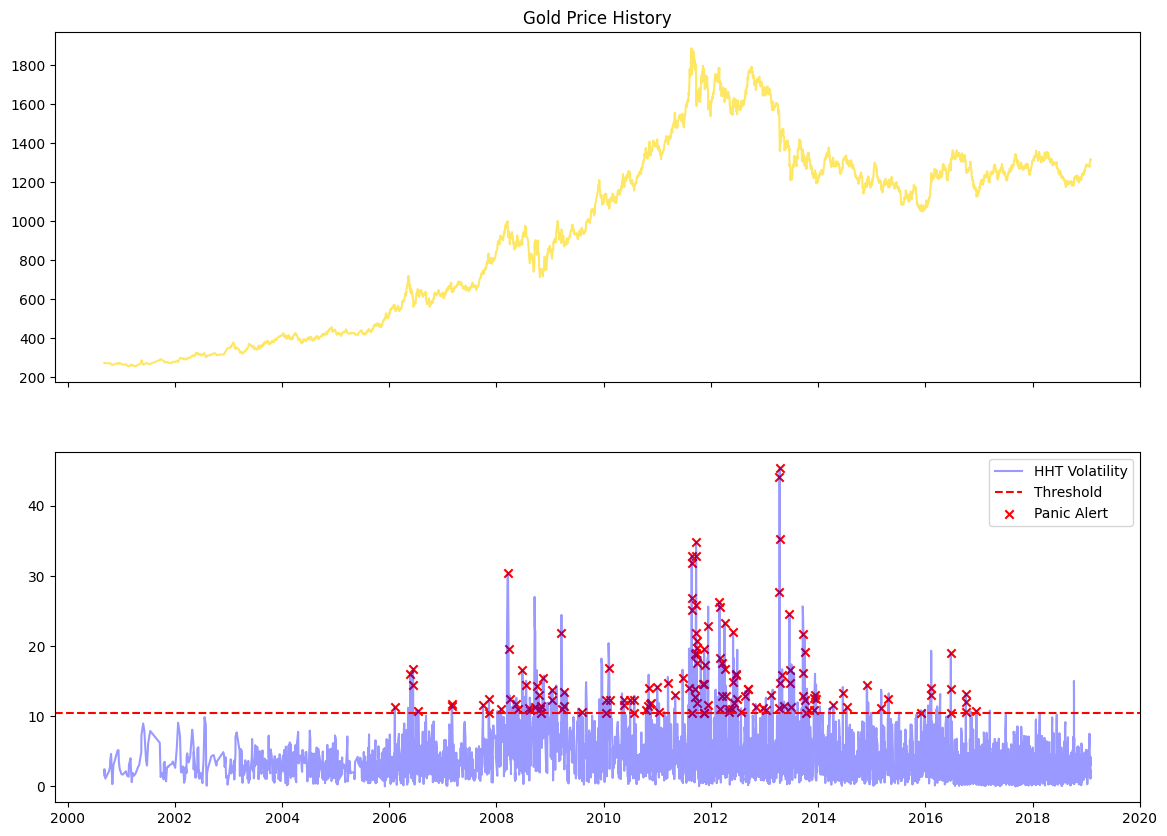


--- Analysis for 2008-01-01 to 2009-12-31 ---
Total Days: 563 | Panic Alerts Found: 24
--------------------------------------------------
Date: 2008-03-20 | Vol: 30.37 | News: gold falls nearly 3%, continuing slide as dollar rallies
Date: 2009-03-18 | Vol: 21.84 | News: april gold ends at the lowest level in two months
Date: 2008-03-24 | Vol: 19.53 | News: april gold down $4.90 to $915.10 an ounce on nymex
Date: 2008-06-25 | Vol: 16.56 | News: gold futures down 70c at $888.50 an ounce
Date: 2008-11-12 | Vol: 15.44 | News: december gold down $2.30 to $730.50 an ounce on globex
Date: 2008-07-23 | Vol: 14.50 | News: august gold down $10.20 to $938.30 an ounce on nymex
Date: 2008-10-02 | Vol: 14.28 | News: gold falls as dollar rises after senate approves plan
Date: 2009-01-12 | Vol: 13.77 | News: gold falls to near $830 as dollar rises
Date: 2009-04-06 | Vol: 13.49 | News: gold falls on optimism worst of crisis may be over
Date: 2008-10-17 | Vol: 12.97 | News: gold falls for seventh day a

In [14]:
#Main Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax1.plot(df_merged['Date'], df_merged['Close'], color='gold', label='Gold Price', alpha=0.6)
ax1.set_title("Gold Price History")

ax2.plot(df_merged['Date'], df_merged['Rolling_HHT_Volatility'], color='blue', alpha=0.4, label='HHT Volatility')
ax2.axhline(vol_threshold, color='red', linestyle='--', label='Threshold')
alerts = df_merged[df_merged['Alert'] == True]
ax2.scatter(alerts['Date'], alerts['Rolling_HHT_Volatility'], color='red', marker='x', label='Panic Alert')
ax2.legend()
plt.show()
# Cross Referencing which news headlines across said dates caused panic alerts
analyze_panic_events(df_merged, '2008-01-01', '2009-12-31')

Plotting Evaluation Metrics

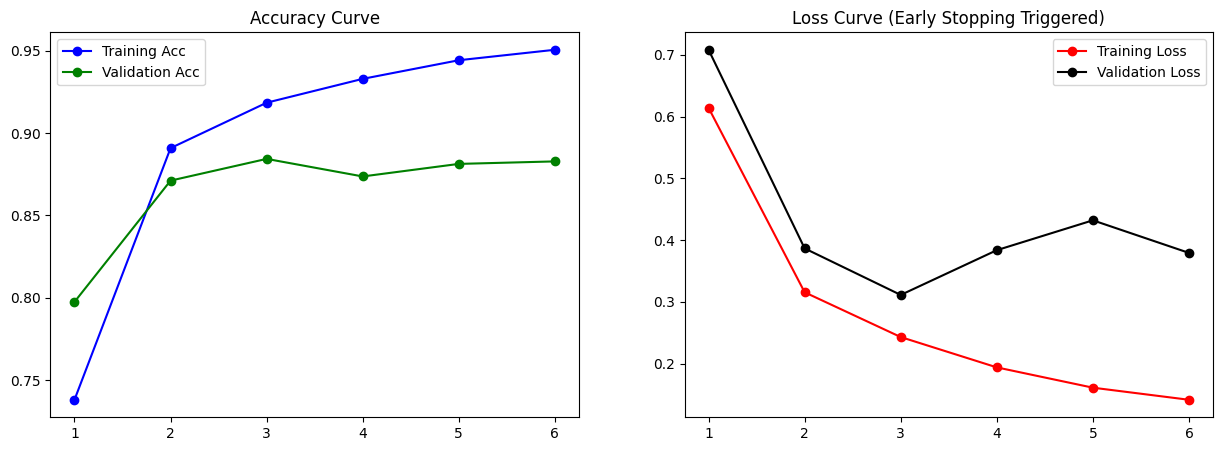

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.92      0.90      0.91       758
     Neutral       0.81      0.76      0.78       419
    Positive       0.89      0.94      0.91       793

    accuracy                           0.88      1970
   macro avg       0.87      0.87      0.87      1970
weighted avg       0.88      0.88      0.88      1970



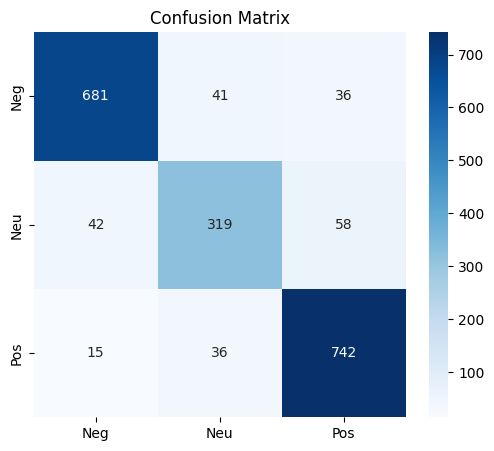

In [15]:
# Run Evaluation
plot_evaluation_metrics(history, model_bilstm, X_test, y_test)

## 6. Ethical Considerations & Responsible AI

### a. Bias & Fairness

News sentiment may reflect media bias

Financial narratives may exaggerate negativity


### b. Dataset Limitations

English-only news

Missing intraday sentiment signals


### c. Responsible Use

Not intended for automated trading

Should be used as a decision-support and historical analysis tool

## 7. Conclusion & Future Scope

### a. Summary of Results

1. Successfully combined signal decomposition + NLP

2. Identified historical panic periods with high precision

3. Demonstrated effectiveness during crisis events



### b. Future Improvements

1. Transformer-based sentiment models (FinBERT)

2. Intraday price + social media data

3. Reinforcement learning for dynamic thresholds

4. Cross-asset panic contagion modeling